In [1]:
import pyarrow as pa
import pandas as pd
import numpy as np
import math
from datetime import datetime

import plotly.express as px
import plotly.io as pio
import pycountry
from cucopy import Currency
import json

from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing

from pydeflate import set_pydeflate_path, imf_gdp_deflate, imf_cpi_e_deflate

import statsmodels.api as sm

# Specify the path where deflator and exchange data will be saved
set_pydeflate_path("pydeflate")

In [2]:
df = pa.ipc.open_stream(open('../companies_eu.arrow', 'rb')).read_all().to_pandas()

quota_countries_30 = ["BEL", "ITA", "PRT"]
quota_countries_33 = ["DEU", "AUT"]
quota_countries_40 = ["NOR", "FRA"]

all_quota_countries = quota_countries_30 + quota_countries_33 + quota_countries_40

In [3]:
# cache = {}


# na_keys = [key for key, value in cache.items() if pd.isna(value)]

# for key in na_keys:
#     cache[key] = None
    
# with open('cache.json', 'w') as file:
#     json.dump(cache if cache else {}, file)
    
with open('cache.json', 'r') as file:
    cache = json.load(file)

In [4]:
# Removing empty companies
df = df[df['gender_directors'].str['male'].notna()]
df = df[df['prices'].apply(len) != 1]
df = df[~((df['gender_directors'].str.get('male') == 0) & (df['gender_directors'].str.get('female') == 0))]
df = df[df['currency'] != "GBX"]
df = df[df['currency'] != "DEM"]


# Calculating gender ratio
def calculate_ratio(gender_dict):
    male = gender_dict.get('male', None)
    female = gender_dict.get('female', None)
    if male is None or female is None:
        return None
    return female / (male + female) if (male + female) > 0 else 0

df['gender_ratio'] = df['gender_directors'].apply(calculate_ratio)


## Converting US -> USA (for plyr)
def convert_country_code(alpha2):
    try:
        return pycountry.countries.get(alpha_2=alpha2).alpha_3
    except:
        return None

df['country_iso3'] = df['country'].apply(convert_country_code)


df

,symbol,name,ticker,currency,exchange,url,sector,country,gender_general,gender_executives,gender_directors,prices,gender_ratio,country_iso3
0,4669.0,LVMH,MC,EUR,Euronext Paris,/quote/stock/LVMH-4669/,Other Apparel & Accessories,fr,"{'male': 18.0, 'female': 9.0}","{'male': 4.0, 'female': 0.0}","{'male': 9.0, 'female': 6.0}","[{'close': 130.81868, 'time': 631155600.0}, {'...",0.400000,FRA
1,436555.0,SAP SE,SAP,EUR,Xetra,/quote/stock/SAP-SE-436555/,Enterprise Software,de,"{'male': 32.0, 'female': 16.0}","{'male': 6.0, 'female': 1.0}","{'male': 12.0, 'female': 7.0}","[{'close': 1.177265, 'time': 694314000.0}, {'c...",0.368421,DEU
2,12002973.0,ASML HOLDING N.V.,ASML,EUR,Euronext Amsterdam,/quote/stock/ASML-HOLDING-N-V-12002973/,Other Semiconductor Equipment & Testing,nl,"{'male': 14.0, 'female': 5.0}","{'male': 5.0, 'female': 1.0}","{'male': 6.0, 'female': 3.0}","[{'close': 1.752633, 'time': 795402000.0}, {'c...",0.333333,NLD
3,4657.0,HERMÈS INTERNATIONAL,RMS,EUR,Euronext Paris,/quote/stock/HERMES-INTERNATIONAL-4657/,Handbags & Luggage,fr,"{'male': 19.0, 'female': 13.0}","{'male': 4.0, 'female': 4.0}","{'male': 7.0, 'female': 6.0}","[{'close': 5.17825, 'time': 744940800.0}, {'cl...",0.461538,FRA
4,4666.0,L'ORÉAL,OR,EUR,Euronext Paris,/quote/stock/L-OREAL-4666/,Cosmetics & Perfumes,fr,"{'male': 21.0, 'female': 11.0}","{'male': 4.0, 'female': 3.0}","{'male': 11.0, 'female': 5.0}","[{'close': 9.51434, 'time': 694314000.0}, {'cl...",0.312500,FRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,168008435.0,FONDUL OAMENILOR DE AFACERI,XFOA,RON,Bucharest S.E.,/quote/stock/FONDUL-OAMENILOR-DE-AFACE-168008435/,Closed End Funds,ro,"{'male': 2.0, 'female': 1.0}","{'male': 0.0, 'female': 1.0}","{'male': 2.0, 'female': 1.0}","[{'close': 2.2, 'time': 1220918400.0}, {'close...",0.333333,ROU
6952,169058764.0,SC CICERO SA,CICE,RON,Bucharest S.E.,/quote/stock/SC-CICERO-SA-169058764/,-,ro,"{'male': 1.0, 'female': 3.0}","{'male': 1.0, 'female': 1.0}","{'male': 1.0, 'female': 2.0}","[{'close': 11.825, 'time': 1350864000.0}, {'cl...",0.666667,ROU
6983,171055825.0,"TEKSTIL, PROIZVODNO IN TRGOVSKO PODJETJE D.D.",TSPG,EUR,Ljubljana S.E.,/quote/stock/TEKSTIL-PROIZVODNO-IN-TRG-171055825/,-,si,"{'male': 2.0, 'female': 1.0}","{'male': 0.0, 'female': 1.0}","{'male': 2.0, 'female': 0.0}","[{'close': 209.0, 'time': 1717977600.0}, {'clo...",0.000000,SVN
6986,173011279.0,"PARTNERS GROUP DIRECT EQUITY V (EUR) S.C.A., S...",246811148,EUR,LUXEMBOURG S.E.,/quote/stock/PARTNERS-GROUP-DIRECT-EQU-173011279/,-,lu,"{'male': 7.0, 'female': 0.0}","{'male': 2.0, 'female': 0.0}","{'male': 2.0, 'female': 0.0}","[{'close': 728.1, 'time': 1695945600.0}, {'clo...",0.000000,LUX


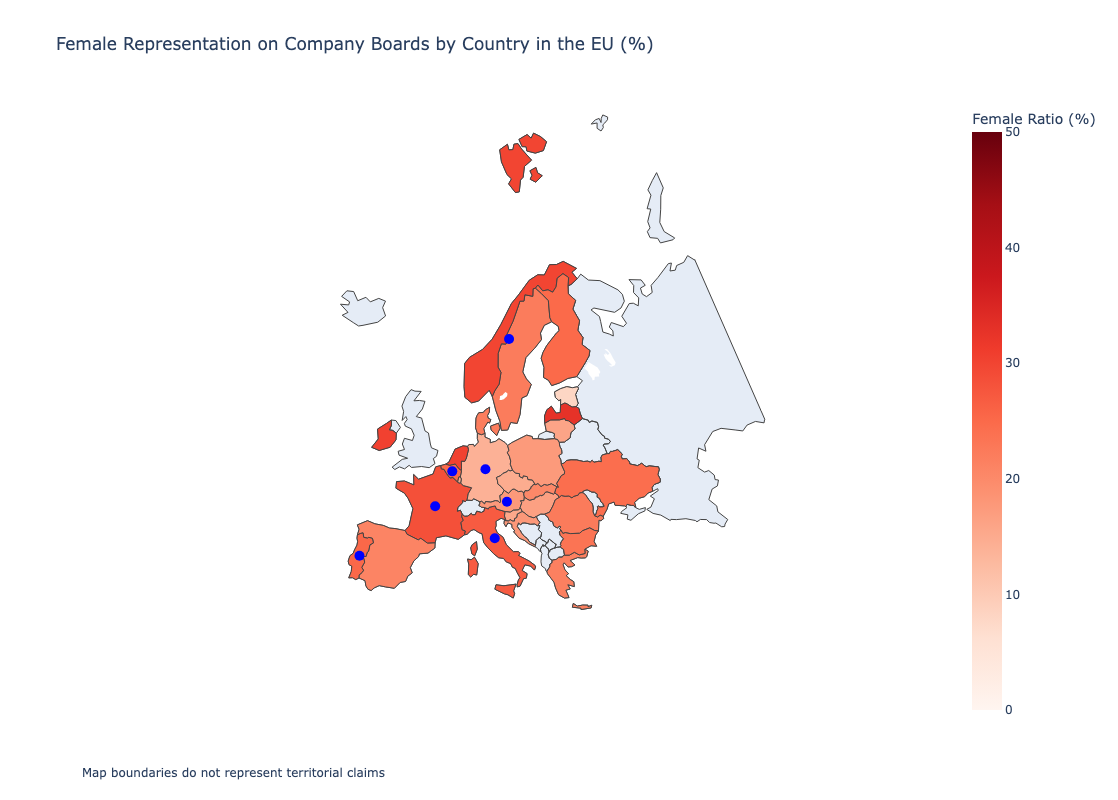

In [6]:
country_ratios = df.groupby('country_iso3', observed=True)['gender_ratio'].mean().reset_index()
country_ratios = df.groupby('country_iso3', observed=True)['gender_ratio'].agg(['mean', 'size']).reset_index()
country_ratios = country_ratios.rename(columns={'size': 'sample_count', 'mean': 'gender_ratio'})

country_ratios['gender_ratio_percent'] = country_ratios['gender_ratio'] * 100


fig = px.choropleth(
    country_ratios,
    locations='country_iso3',
    locationmode='ISO-3',
    color='gender_ratio_percent',
    hover_name='country_iso3',
    color_continuous_scale="Reds",
    title='Female Representation on Company Boards by Country in the EU (%)',
    labels={'gender_ratio_percent': 'Female Ratio (%)'},
    range_color=[0, 50],
    scope="europe"
)

fig.update_layout(
    width=1000,
    height=800
)

fig.add_annotation(
    text="Map boundaries do not represent territorial claims",
    xref="paper", yref="paper",
    x=0, y=-0.1,
    showarrow=False
)


fig.add_scattergeo(
    locations=all_quota_countries,
    locationmode='ISO-3',
    marker=dict(size=10, color='blue', symbol='circle'),
    name='Countries with Quota',
    legendgroup='quota'
)

fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)


pio.write_image(
    fig,
    'plot_map.png',
    scale=3, 
    width=1000, 
    height=800 
)


fig

In [7]:
country_ratios['gender_ratio_percent'] = np.round(country_ratios['gender_ratio_percent'])
country_ratios['country_name'] = country_ratios['country_iso3'].map(lambda x: pycountry.countries.get(alpha_3=x).name)

ordered_table = country_ratios.sort_values(by='gender_ratio_percent', ascending=False)

def get_quota(country_iso3):
    if country_iso3 in quota_countries_30:
        return '30% quota'
    elif country_iso3 in quota_countries_33:
        return '33% quota'
    elif country_iso3 in quota_countries_40:
        return '40% quota'
    return ''

ordered_table['is_quota'] = ordered_table['country_iso3'].apply(get_quota)


ordered_table.drop('country_iso3', axis=1, inplace=True)
ordered_table.drop('gender_ratio', axis=1, inplace=True)

ordered_table.set_index('country_name', inplace=True)


ordered_table

,sample_count,gender_ratio_percent,is_quota
country_name,,,
Latvia,10,33.0,
Norway,341,30.0,40% quota
Netherlands,103,30.0,
Ireland,21,30.0,
France,761,28.0,40% quota
Italy,427,27.0,30% quota
Portugal,44,25.0,30% quota
Belgium,170,25.0,30% quota
Finland,176,25.0,


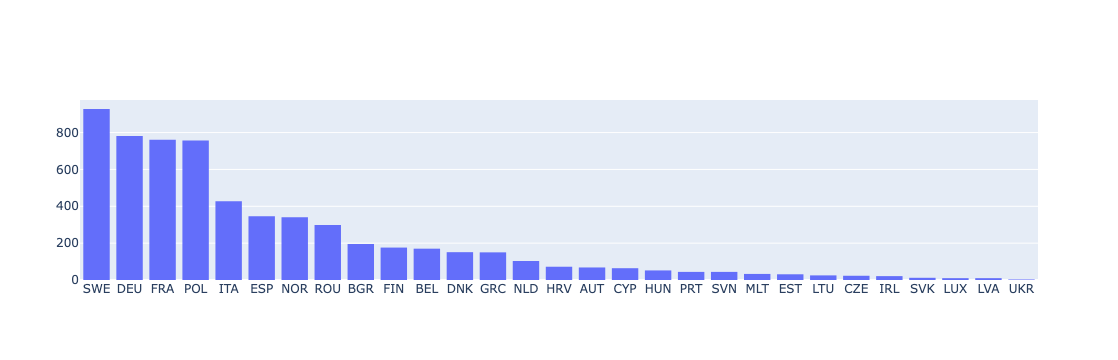

In [8]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=df['country_iso3'], histfunc="count"))
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [9]:
def currency_to_iso(currency: str):
    m = {
        "USD": "us",
        "EUR": "de",
        "SEK": "sk",
        "PLN": "pl",
        "NOK": "no",
        "RON": "ro",
        "BGN": "bg",
        "DKK": "dk",
        "HUF": "hu",
        "CZK": "cz",
        "CHF": "se",
        "LVL": "lv",
        "UAH": "ua"
    }
    return m[currency]

def currency_to_iso2(currency: str):
    m = {
        "USD": "USA",
        "EUR": "DEU",
        "SEK": "SWE",
        "PLN": "POL",
        "NOK": "NOR",
        "RON": "ROU",
        "BGN": "BGR",
        "DKK": "DNK",
        "HUF": "HUN",
        "CZK": "CZE",
        "CHF": "CHE",
        "LVL": "LVA",
        "UAH": "UKR",
    }
    return m[currency]


In [10]:
# This function relies on IMF API -- hence, it's very slow for 6k records
def inflate(year: int, price: float, currency: str):
    cache_key = f"{year}_{price}_{currency}"
    if cache_key in cache:
        return cache[cache_key]
    
    inflator = Currency(recording_year=str(year if year != 2024 else 2023), value=price, iso=currency_to_iso(currency))
    inflator.set_target_year("2023")
    inflator.set_target_currency("us")
    us = inflator.get_exchanged_value()
    inflator.value = us
    worth = inflator.get_equivalent_worth()
    cache[cache_key] = worth
    return worth


def inflate2(year: int, price: float, currency: str):
    cache_key = f"2_{year}_{price}_{currency}"
    if cache_key in cache:
        return cache[cache_key]
        
    # Convert to constant USD 2015 prices
    df_constant = imf_cpi_e_deflate(
        data=pd.DataFrame({
            'iso_code': [currency_to_iso2(currency)],
            'year': [year],
            'value': [price]
        }),
        base_year=2015,
        source_currency=currency_to_iso2(currency),
        target_currency="USA", 
        year_column="year",
        value_column="value",
        target_value_column="value_constant" 
    )
    cache[cache_key] =  df_constant['value_constant'][0]
    return df_constant['value_constant'][0]

def calculate_cagr(stock_data, currency):
    stock_df = pd.DataFrame(list(stock_data))
    
    first_year = datetime.fromtimestamp(stock_df['time'].iloc[0]).year
    last_year = datetime.fromtimestamp(stock_df['time'].iloc[-1]).year
    
    # print((first_year, last_year, stock_df['close'].iloc[0], stock_df['close'].iloc[-1], currency))
    first_price = inflate2(first_year, stock_df['close'].iloc[0], currency)
    last_price = inflate2(last_year, stock_df['close'].iloc[-1], currency)
   
    if first_price == None or last_price == None or pd.isna(first_price) or pd.isna(last_price) or first_price == 0 or last_price == 0 or max(last_year - first_year, 1) <= 4:
        return -100


    years = max(last_year - first_year, 1)
    cagr = (((last_price / first_price) ** (1/years)) - 1) * 100
    
    return cagr

print(calculate_cagr(df['prices'][3], df['currency'][3]))
print(df['currency'][3])

# df['cagr'] = df.apply()

19.036134086256528
EUR


In [11]:
i = 0
def calc_row_cagr(row):
    global i
    i += 1
    cagr = calculate_cagr(row['prices'], row['currency'])
    # print(i, cagr)
    return cagr

df['cagr'] = df.apply(calc_row_cagr, axis=1)

2024-12-13 23:59:24,117 - pydeflate - INFO:
 Reading WEO data from /Users/mark/_work/kse_sociology/exploration/pydeflate/weo_2024-12-13.parquet
2024-12-13 23:59:24,462 - pydeflate - INFO:
 Reading WEO data from /Users/mark/_work/kse_sociology/exploration/pydeflate/weo_2024-12-13.parquet
2024-12-13 23:59:25,919 - pydeflate - INFO:
 Reading WEO data from /Users/mark/_work/kse_sociology/exploration/pydeflate/weo_2024-12-13.parquet
2024-12-13 23:59:26,143 - pydeflate - INFO:
 Reading WEO data from /Users/mark/_work/kse_sociology/exploration/pydeflate/weo_2024-12-13.parquet
2024-12-13 23:59:29,423 - pydeflate - INFO:
 Reading WEO data from /Users/mark/_work/kse_sociology/exploration/pydeflate/weo_2024-12-13.parquet
2024-12-13 23:59:29,588 - pydeflate - INFO:
 Reading WEO data from /Users/mark/_work/kse_sociology/exploration/pydeflate/weo_2024-12-13.parquet


In [12]:
df = df[df['cagr'] != -100]
df

,symbol,name,ticker,currency,exchange,url,sector,country,gender_general,gender_executives,gender_directors,prices,gender_ratio,country_iso3,cagr
1,436555.0,SAP SE,SAP,EUR,Xetra,/quote/stock/SAP-SE-436555/,Enterprise Software,de,"{'male': 32.0, 'female': 16.0}","{'male': 6.0, 'female': 1.0}","{'male': 12.0, 'female': 7.0}","[{'close': 1.177265, 'time': 694314000.0}, {'c...",0.368421,DEU,15.549294
2,12002973.0,ASML HOLDING N.V.,ASML,EUR,Euronext Amsterdam,/quote/stock/ASML-HOLDING-N-V-12002973/,Other Semiconductor Equipment & Testing,nl,"{'male': 14.0, 'female': 5.0}","{'male': 5.0, 'female': 1.0}","{'male': 6.0, 'female': 3.0}","[{'close': 1.752633, 'time': 795402000.0}, {'c...",0.333333,NLD,20.391660
3,4657.0,HERMÈS INTERNATIONAL,RMS,EUR,Euronext Paris,/quote/stock/HERMES-INTERNATIONAL-4657/,Handbags & Luggage,fr,"{'male': 19.0, 'female': 13.0}","{'male': 4.0, 'female': 4.0}","{'male': 7.0, 'female': 6.0}","[{'close': 5.17825, 'time': 744940800.0}, {'cl...",0.461538,FRA,19.036134
4,4666.0,L'ORÉAL,OR,EUR,Euronext Paris,/quote/stock/L-OREAL-4666/,Cosmetics & Perfumes,fr,"{'male': 21.0, 'female': 11.0}","{'male': 4.0, 'female': 3.0}","{'male': 11.0, 'female': 5.0}","[{'close': 9.51434, 'time': 694314000.0}, {'cl...",0.312500,FRA,9.535789
5,16943135.0,INDITEX,ITX,EUR,BME,/quote/stock/INDITEX-16943135/,Other Apparel & Accessories Retailers,es,"{'male': 13.0, 'female': 7.0}","{'male': 4.0, 'female': 1.0}","{'male': 5.0, 'female': 5.0}","[{'close': 3.6, 'time': 990576000.0}, {'close'...",0.500000,ESP,10.061528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6946,167693188.0,S.C. VITIMAS S.A.,VITK,RON,Bucharest S.E.,/quote/stock/S-C-VITIMAS-S-A-167693188/,-,ro,"{'male': 2.0, 'female': 0.0}","{'male': 1.0, 'female': 0.0}","{'male': 1.0, 'female': 0.0}","[{'close': 0.5, 'time': 1248998400.0}, {'close...",0.000000,ROU,17.907301
6947,167693815.0,S.C. GRUPUL EDITORILOR SI DIFUZORILOR DE PRESA...,GDP,RON,Bucharest S.E.,/quote/stock/S-C-GRUPUL-EDITORILOR-SI--167693815/,-,ro,"{'male': 0.0, 'female': 2.0}","{'male': 0.0, 'female': 2.0}","{'male': 0.0, 'female': 1.0}","[{'close': 0.0146, 'time': 1094774400.0}, {'cl...",1.000000,ROU,46.817260
6948,168008434.0,S.C. LIDO SA,LIDO,RON,Bucharest S.E.,/quote/stock/S-C-LIDO-SA-168008434/,-,ro,"{'male': 2.0, 'female': 1.0}","{'male': 1.0, 'female': 0.0}","{'male': 1.0, 'female': 1.0}","[{'close': 2.2, 'time': 1220832000.0}, {'close...",0.500000,ROU,-14.679405
6949,168008435.0,FONDUL OAMENILOR DE AFACERI,XFOA,RON,Bucharest S.E.,/quote/stock/FONDUL-OAMENILOR-DE-AFACE-168008435/,Closed End Funds,ro,"{'male': 2.0, 'female': 1.0}","{'male': 0.0, 'female': 1.0}","{'male': 2.0, 'female': 1.0}","[{'close': 2.2, 'time': 1220918400.0}, {'close...",0.333333,ROU,-7.973091


In [13]:
# Removing the outliers & sectors with low representation
Q1 = df['cagr'].quantile(0.25)
Q3 = df['cagr'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = df[(df['cagr'] >= lower_bound) & (df['cagr'] <= upper_bound)]

sector_counts = filtered_df['sector'].value_counts()
sectors_to_keep = sector_counts[sector_counts >= 80].index

filtered_df = filtered_df[filtered_df['sector'].isin(sectors_to_keep)]
filtered_df

,symbol,name,ticker,currency,exchange,url,sector,country,gender_general,gender_executives,gender_directors,prices,gender_ratio,country_iso3,cagr
27,4618.0,BNP PARIBAS,BNP,EUR,Euronext Paris,/quote/stock/BNP-PARIBAS-4618/,Other Banks,fr,"{'male': 61.0, 'female': 17.0}","{'male': 5.0, 'female': 3.0}","{'male': 9.0, 'female': 6.0}","[{'close': 20.65919, 'time': 750992400.0}, {'c...",0.400000,FRA,1.370928
32,4725.0,VINCI,DG,EUR,Euronext Paris,/quote/stock/VINCI-4725/,Other Construction & Engineering,fr,"{'male': 19.0, 'female': 6.0}","{'male': 6.0, 'female': 0.0}","{'male': 9.0, 'female': 4.0}","[{'close': 7.069293, 'time': 694314000.0}, {'c...",0.307692,FRA,6.517370
41,56358303.0,ING GROEP N.V.,INGA,EUR,Euronext Amsterdam,/quote/stock/ING-GROEP-N-V-56358303/,Other Banks,nl,"{'male': 13.0, 'female': 5.0}","{'male': 4.0, 'female': 0.0}","{'male': 7.0, 'female': 2.0}","[{'close': 9.4, 'time': 668826000.0}, {'close'...",0.222222,NLD,-0.651752
57,46475557.0,NORDEA BANK ABP,NDA FI,EUR,Nasdaq Helsinki,/quote/stock/NORDEA-BANK-ABP-46475557/,Other Banks,fi,"{'male': 19.0, 'female': 11.0}","{'male': 6.0, 'female': 2.0}","{'male': 9.0, 'female': 5.0}","[{'close': 9.5, 'time': 1538352000.0}, {'close...",0.357143,FIN,-1.537719
59,357103.0,"CAIXABANK, S.A.",CABK,EUR,BME,/quote/stock/CAIXABANK-S-A-357103/,Other Banks,es,"{'male': 24.0, 'female': 7.0}","{'male': 7.0, 'female': 1.0}","{'male': 11.0, 'female': 5.0}","[{'close': 5.1938, 'time': 1192060800.0}, {'cl...",0.312500,ESP,-2.156188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6929,160189196.0,DEBITUM INVEST SPV-SOFIA,DBMI,BGN,Bulgaria S.E.,/quote/stock/DEBITUM-INVEST-SPV-SOFIA-160189196/,-,bg,"{'male': 2.0, 'female': 0.0}","{'male': 2.0, 'female': 0.0}","{'male': 1.0, 'female': 0.0}","[{'close': 1.02, 'time': 1318809600.0}, {'clos...",0.000000,BGR,-6.708601
6931,162598922.0,ZASAVSKI RACUNSKI CENTER D.D.,ZRCG,EUR,Ljubljana S.E.,/quote/stock/ZASAVSKI-RACUNSKI-CENTER--162598922/,-,si,"{'male': 1.0, 'female': 0.0}","{'male': 0.0, 'female': 0.0}","{'male': 1.0, 'female': 0.0}","[{'close': 1.752629, 'time': 985737600.0}, {'c...",0.000000,SVN,5.746531
6946,167693188.0,S.C. VITIMAS S.A.,VITK,RON,Bucharest S.E.,/quote/stock/S-C-VITIMAS-S-A-167693188/,-,ro,"{'male': 2.0, 'female': 0.0}","{'male': 1.0, 'female': 0.0}","{'male': 1.0, 'female': 0.0}","[{'close': 0.5, 'time': 1248998400.0}, {'close...",0.000000,ROU,17.907301
6948,168008434.0,S.C. LIDO SA,LIDO,RON,Bucharest S.E.,/quote/stock/S-C-LIDO-SA-168008434/,-,ro,"{'male': 2.0, 'female': 1.0}","{'male': 1.0, 'female': 0.0}","{'male': 1.0, 'female': 1.0}","[{'close': 2.2, 'time': 1220832000.0}, {'close...",0.500000,ROU,-14.679405


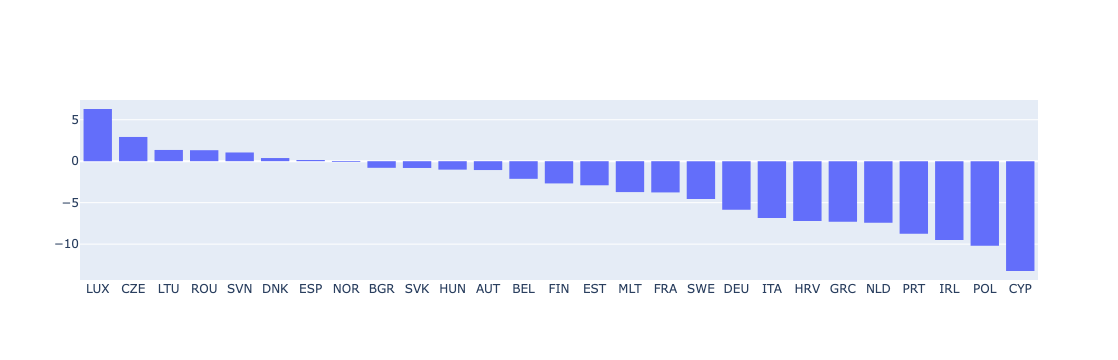

In [24]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=filtered_df['country_iso3'],
    y=filtered_df['cagr'],
    histfunc='avg'
))
fig.update_xaxes(categoryorder='total descending')
fig.show()


/var/folders/bp/65nrxg9n073byd5s0stpt9680000gp/T/ipykernel_9955/499575543.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



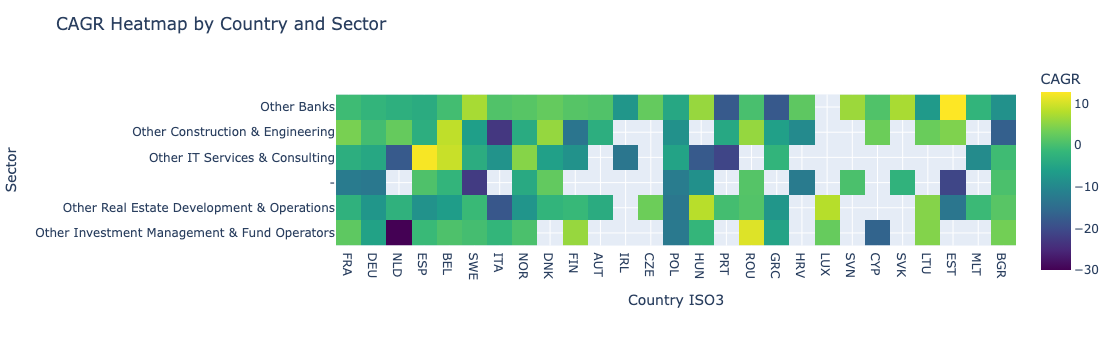

In [25]:
heatmap_data = filtered_df.pivot_table(index='sector', columns='country_iso3', values='cagr', aggfunc='mean')

fig = px.imshow(heatmap_data,
                labels=dict(x="Country ISO3", y="Sector", color="CAGR"),
                x=heatmap_data.columns,
                y=heatmap_data.index,
                color_continuous_scale='Viridis')

fig.update_layout(title="CAGR Heatmap by Country and Sector",
                 xaxis_title="Country ISO3",
                 yaxis_title="Sector")

fig.show()


In [26]:
all_quota_countries = quota_countries_30 + quota_countries_33 + quota_countries_40

df_quota = filtered_df[filtered_df['country_iso3'].isin(all_quota_countries)]
df_non_quota = filtered_df[~filtered_df['country_iso3'].isin(all_quota_countries)]
df_quota

,symbol,name,ticker,currency,exchange,url,sector,country,gender_general,gender_executives,gender_directors,prices,gender_ratio,country_iso3,cagr
27,4618.0,BNP PARIBAS,BNP,EUR,Euronext Paris,/quote/stock/BNP-PARIBAS-4618/,Other Banks,fr,"{'male': 61.0, 'female': 17.0}","{'male': 5.0, 'female': 3.0}","{'male': 9.0, 'female': 6.0}","[{'close': 20.65919, 'time': 750992400.0}, {'c...",0.400000,FRA,1.370928
32,4725.0,VINCI,DG,EUR,Euronext Paris,/quote/stock/VINCI-4725/,Other Construction & Engineering,fr,"{'male': 19.0, 'female': 6.0}","{'male': 6.0, 'female': 0.0}","{'male': 9.0, 'female': 4.0}","[{'close': 7.069293, 'time': 694314000.0}, {'c...",0.307692,FRA,6.517370
67,56358396.0,DEUTSCHE BANK AG,DBK,EUR,Xetra,/quote/stock/DEUTSCHE-BANK-AG-56358396/,Other Banks,de,"{'male': 76.0, 'female': 16.0}","{'male': 10.0, 'female': 3.0}","{'male': 14.0, 'female': 6.0}","[{'close': 32.93655, 'time': 694314000.0}, {'c...",0.300000,DEU,-4.115947
81,5967.0,KBC GROUPE NV,KBC,EUR,Euronext Bruxelles,/quote/stock/KBC-GROUPE-NV-5967/,Other Banks,be,"{'male': 17.0, 'female': 3.0}","{'male': 3.0, 'female': 0.0}","{'male': 13.0, 'female': 2.0}","[{'close': 9.9444, 'time': 694314000.0}, {'clo...",0.133333,BEL,4.141022
86,4624.0,CAPGEMINI SE,CAP,EUR,Euronext Paris,/quote/stock/CAPGEMINI-SE-4624/,Other IT Services & Consulting,fr,"{'male': 21.0, 'female': 15.0}","{'male': 6.0, 'female': 4.0}","{'male': 8.0, 'female': 6.0}","[{'close': 41.12064, 'time': 694314000.0}, {'c...",0.428571,FRA,2.144916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6792,22512662.0,PIONEER PROPERTY GROUP ASA,PPG,NOK,Oslo Bors,/quote/stock/PIONEER-PROPERTY-GROUP-AS-22512662/,-,no,"{'male': 5.0, 'female': 2.0}","{'male': 2.0, 'female': 0.0}","{'male': 3.0, 'female': 2.0}","[{'close': 105.0, 'time': 1434672000.0}, {'clo...",0.400000,NOR,-4.068299
6821,22865569.0,MAATSCHAPPIJ VAN DE BRUGSE ZEEHAVEN NV,001034260,EUR,Euronext Bruxelles,/quote/stock/MAATSCHAPPIJ-VAN-DE-BRUGS-22865569/,-,be,"{'male': 9.0, 'female': 6.0}","{'male': 1.0, 'female': 0.0}","{'male': 9.0, 'female': 6.0}","[{'close': 124.5, 'time': 1440460800.0}, {'clo...",0.400000,BEL,-2.839815
6822,23365064.0,NMC SA,003596676,EUR,Euronext Bruxelles,/quote/stock/NMC-SA-23365064/,-,be,"{'male': 4.0, 'female': 0.0}","{'male': 2.0, 'female': 0.0}","{'male': 3.0, 'female': 0.0}","[{'close': 2250.6, 'time': 1442275200.0}, {'cl...",0.000000,BEL,-2.838088
6824,24706782.0,CREDIMO HOLDING NV,016286805,EUR,Euronext Bruxelles,/quote/stock/CREDIMO-HOLDING-NV-24706782/,-,be,"{'male': 7.0, 'female': 2.0}","{'male': 1.0, 'female': 0.0}","{'male': 7.0, 'female': 2.0}","[{'close': 32.84, 'time': 1448326800.0}, {'clo...",0.222222,BEL,-2.896225


/var/folders/bp/65nrxg9n073byd5s0stpt9680000gp/T/ipykernel_9955/2640350805.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bp/65nrxg9n073byd5s0stpt9680000gp/T/ipykernel_9955/2640350805.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



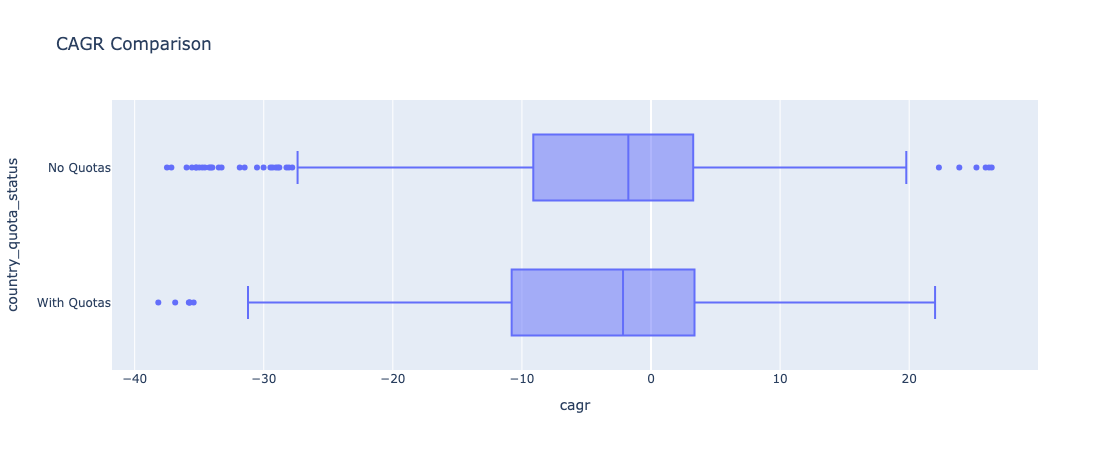

In [35]:
import plotly.express as px
import pandas as pd

df_quota['country_quota_status'] = 'With Quotas'
df_non_quota['country_quota_status'] = 'No Quotas'
combined_df = pd.concat([df_quota, df_non_quota])

fig = px.box(combined_df, 
             y='country_quota_status',
             x='cagr',
             title='CAGR Comparison')

fig.update_layout(
    width=1300,
    height=450
)


pio.write_image(
    fig,
    'plot_box_all.png',
    scale=7, 
    width=1300, 
    height=450 
)


fig.show()

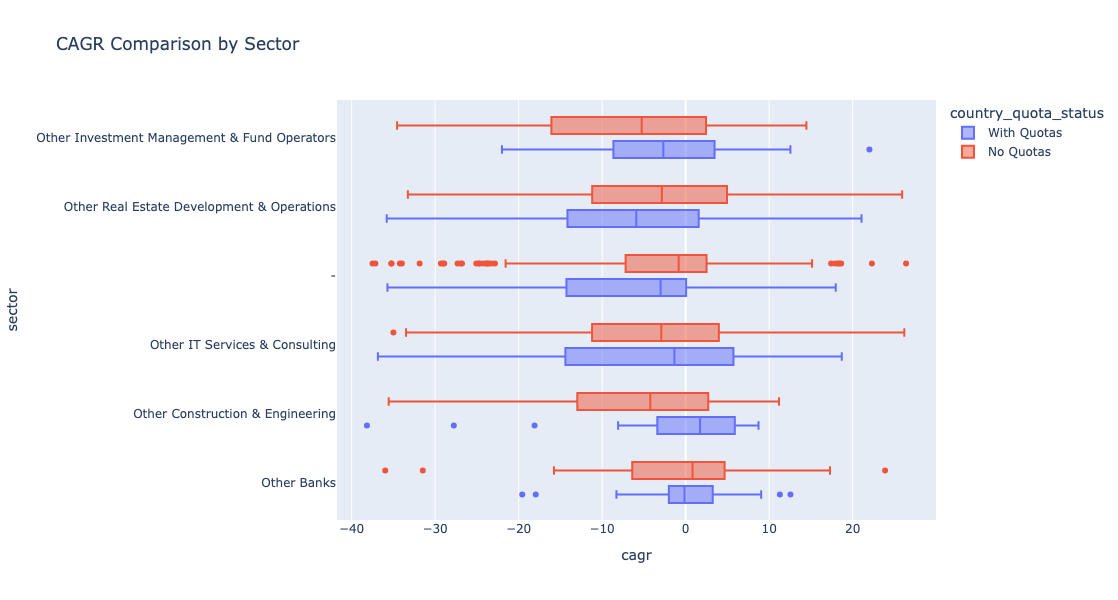

In [34]:
import plotly.express as px

fig = px.box(combined_df, 
             x='cagr',       
             y='sector',    
             color='country_quota_status',
             title='CAGR Comparison by Sector',
             orientation='h') 

fig.update_layout(height=len(combined_df['sector'].unique()) * 50 + 200)


fig.update_layout(
    width=1300,
    height=600
)


pio.write_image(
    fig,
    'plot_box_sectors.png',
    scale=7, 
    width=1300, 
    height=600 
)


fig.show()



In [187]:
combined_df = combined_df.reset_index(drop=True)

model = sm.OLS.from_formula('cagr ~ C(sector) + C(country_quota_status)', data=combined_df)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   cagr   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.684
Date:                Fri, 13 Dec 2024   Prob (F-statistic):             0.0137
Time:                        18:56:40   Log-Likelihood:                -3627.6
No. Observations:                 951   AIC:                             7269.
Df Residuals:                     944   BIC:                             7303.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [195]:
significant_coefs = results.params[results.pvalues < 0.6]
confidence_levels = (1 - results.pvalues[results.pvalues < 0.6]) * 100

data = list(zip(significant_coefs.index, significant_coefs, confidence_levels))
sorted_data = sorted(data, key=lambda x: x[2], reverse=True)

for coef_name, coef_value, conf_level in sorted_data:
    print(f"{coef_value:.6f}\t(Confidence Level: {conf_level:.2f}%)\t-- {coef_name}")

-3.016587	(Confidence Level: 100.00%)	-- Intercept
3.069058	(Confidence Level: 99.90%)	-- C(sector)[T.Other Banks]
0.000000	(Confidence Level: 99.05%)	-- C(sector)[T.Other Apparel & Accessories Retailers]
-0.000000	(Confidence Level: 98.84%)	-- C(sector)[T.Other Electrical Components & Equipment]
0.000000	(Confidence Level: 96.63%)	-- C(sector)[T.Other Semiconductor Equipment & Testing]
-1.982145	(Confidence Level: 94.44%)	-- C(sector)[T.Other Construction & Engineering]
-1.712903	(Confidence Level: 88.10%)	-- C(sector)[T.Other Investment Management & Fund Operators]
-1.191608	(Confidence Level: 85.80%)	-- C(sector)[T.Other Real Estate Development & Operations]
-0.000000	(Confidence Level: 67.58%)	-- C(sector)[T.Enterprise Software]
-0.694963	(Confidence Level: 59.81%)	-- C(country_quota_status)[T.With Quotas]
-0.756105	(Confidence Level: 58.77%)	-- C(sector)[T.Other IT Services & Consulting]
-0.442884	(Confidence Level: 52.75%)	-- C(sector)[T.-]
